# End-to-end Multi-class Dog Breed Classification

This builds a complete image classifier using TensorFlow and TensorFlow Hub

## 1. Problem

Identifying the breed of a dog given an image.

## 2. Data

The data used is from Kaggle's bog breed competition.

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

## 4. Features

Some information about the data: 
* Unstructured Data (images).
* There are 120 breeds of dogs (120 different classes)
* There are more than 10,000 images in the training and test sets. The training set has labels and the the test set has no lables since it needs to be predicted.

Project Data Link: https://www.kaggle.com/c/dog-breed-identification

## Get the work space ready.

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Use a GPU

In [59]:
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version", tf.__version__)

# Check GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.2.0
TF Hub version 2.2.0
GPU available


## Get data ready

Turn all images into tensors (numerical representations)

In [60]:
# Checkout the labels of the data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Colab Notebooks/dog-breed-identification/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     3773d21aa21c6fdb06a9f5980dbb6784  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [61]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

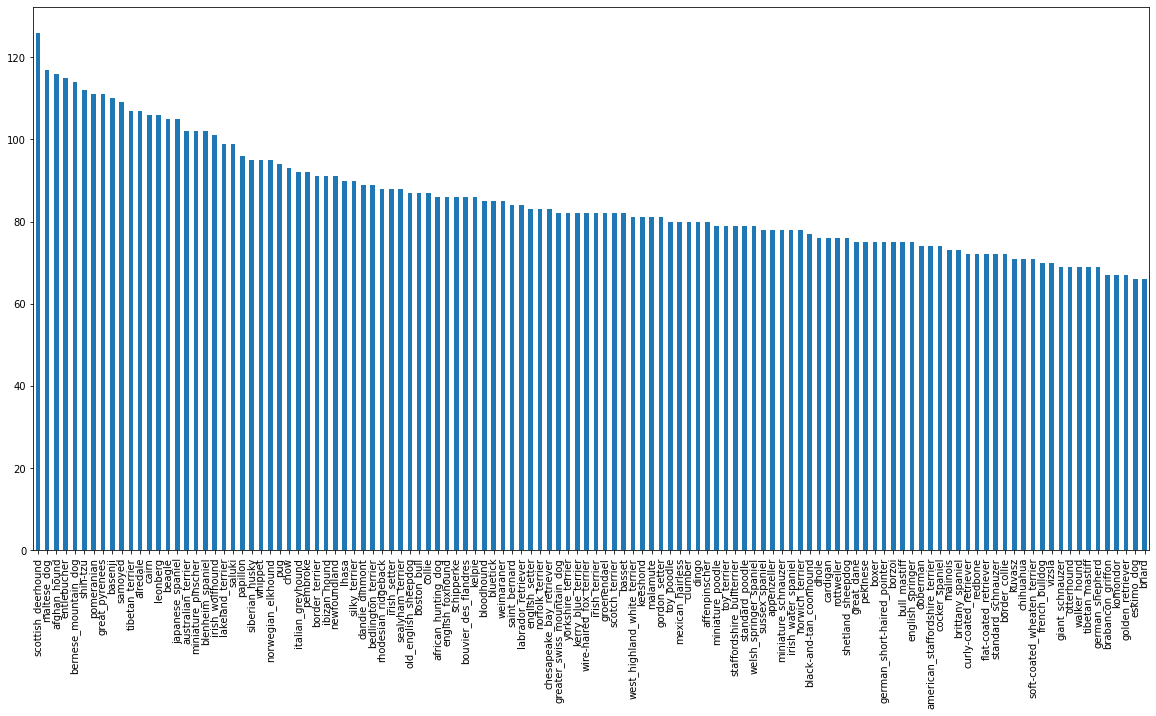

In [62]:
# How many images are there of each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [63]:
labels_csv["breed"].value_counts().median()

82.0

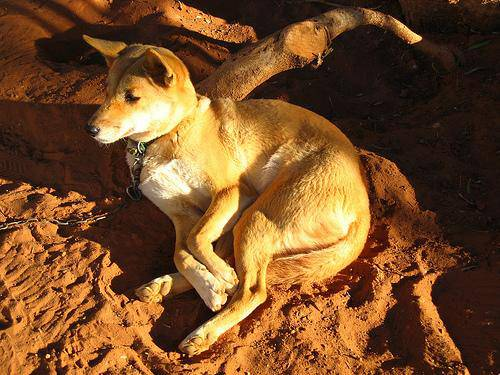

In [64]:
from IPython.display import Image
Image("drive/My Drive/Colab Notebooks/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Get a list of all image file pathnames

In [65]:
# Create pathnames from image IDs
filenames = ["drive/My Drive/Colab Notebooks/dog-breed-identification/train/" + fname + ".jpg" for fname in labels_csv["id"]]

filenames[:10]

['drive/My Drive/Colab Notebooks/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/train/0042188c8

In [66]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/My Drive/Colab Notebooks/dog-breed-identification/train/")) == len(filenames):
  print("Yes")
else:
  print("No")

No


Prepare labels now since all training image filepaths are in a list.

In [67]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [68]:
len(labels)

10222

In [69]:
# See if number of lables matches number of filenames
if len(labels) == len(filenames):
  print("Numer of labels matches number of filenames")
else:
  print("Check data.")

Numer of labels matches number of filenames


In [70]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [71]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [72]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [73]:
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [74]:
len(boolean_labels)

10222

In [75]:
# Example: Turning boolean array into integers
print(labels[0]) # Original label
print(np.where(unique_breeds == labels[0])) # Index where label occurs
print(boolean_labels[0].argmax()) # Index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Create validation set
Kaggle doesn't come with its own validation set.

In [76]:
# Setup x and y variables
x, y = filenames, boolean_labels

Experimenting with ~1000 images and increase when needed.

In [77]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type: "slider", min: 1000, max: 10000, step: 100}

In [78]:
# Split data into train and validation
from sklearn.model_selection import train_test_split

# Split the data into training and validation of total size NUM_IMAGES
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)

len(x_train), len(y_train), len(x_val), len(y_val)

(800, 800, 200, 200)

In [79]:
x_train[:2], y_train[:2]

(['drive/My Drive/Colab Notebooks/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Colab Notebooks/dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,

## Preprocessing Images (turning images into Tensors)

The preprocessing function does:
1. Take an image filepath as an input
2. Use TensorFlow to read the file and save it to a variable `image`
3. Turn the `image` (a .jpg file) into Tensors
4. Normalize the `image` (convert color channel values between 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

First, check what importing an image looks like

In [80]:
# Convert an image to a NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [81]:
image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

In [82]:
# Turn image into a Tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [83]:
# Define image size
IMG_SIZE = 224
# Create a function for preprocessing the images
def process_image(image_path):
  """
  Takes an image file path an turns the image into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)

  # Turn the .jpg image into a numerical Tensor with three color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the color channel values from 0-255 to 0-1 values. This is called normalization. It improves efficiency
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to the desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning the data into batches

If processing 10,000+ images in on go, they might not fit into the memory. So 32 images (batch size) are used at a time.

In order to use TensorFlow effectively, the data needs to be in Tensor tuples which look like this:
`(image, label)`

In [84]:
# Create a function to return a tuple of Tensors (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and assosciated label, processes the image and return the tuple of (image, label)
  """

  image = process_image(image_path)
  return image, label

In [85]:
# Demo of the above function
(process_image(x[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now there is a way to turn data into tuples of Tensors in the form: `(image, label)`, now create a function to turn all the data, `(x, y)`, into batches. 

In [86]:
# Define the batch size: 32
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [87]:
# Create training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [88]:
# Check out the different attributes of the data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualizing Data Batches

Data is now in batches, however, they are hard to understand.

In [89]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

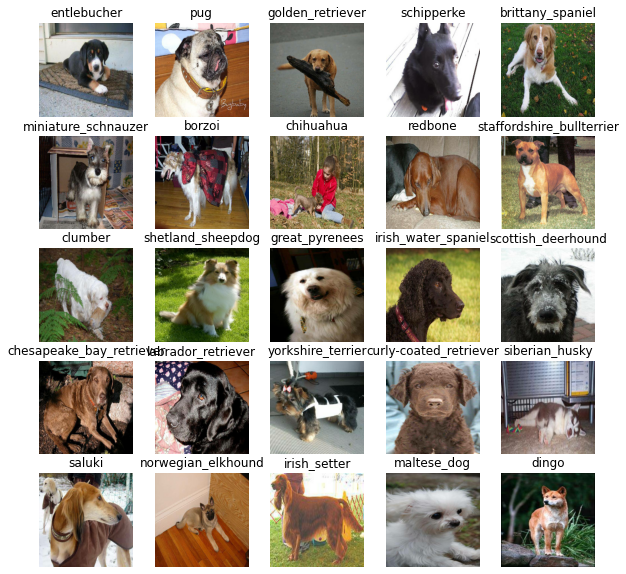

In [90]:
# Visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

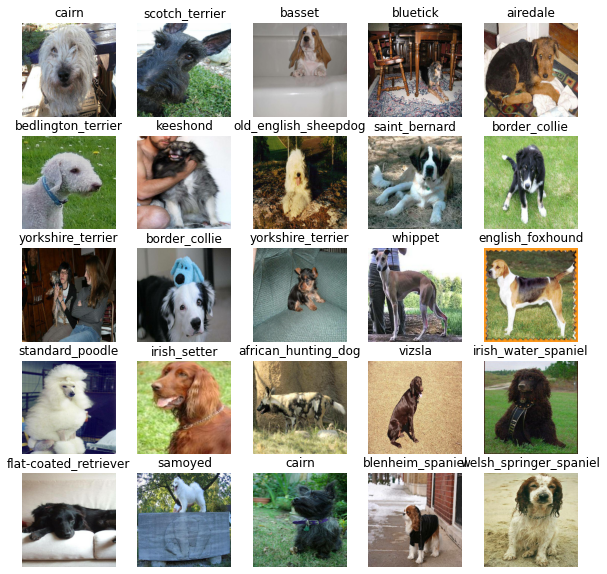

In [91]:
# Visualize the validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before building the model, there are a few things to define:
* The input shape (images shape in the form of Tensors) to our model
* The output shape (image labels in the form of Tensors) of our model.
* The URL of the model needed.

In [92]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Inputs, outputs, and model are ready to go. Put them in a Keras deep learning model.

Now create a function which:
* Takes the input shape, output shape, and the model we've chosen as parameters.
* Defines layers is a Keras model in sequential fashion.
* Compiles the model (says how it should be evaluated and improved)
* Builds the model (tells the model the input shape it will be getting)
* Returns the model

Steps can be found here: https://tensorflow.org/guide/keras/overview

In [93]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
  return model

In [94]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   multiple                  5432713   
_________________________________________________________________
dense_2 (Dense)              multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Create Callbacks

Callbacks are helper functions models can use during training to do things like save progress, check its progress, or stop its training if it stops improving.

Two callbacks will be created:
* TensorBoard: track progress.
* Early stopping: prevents the model from training too long.

### TensorBoard Callback

Setup TensorBoard Steps:
1. Load the TensorBoard notebook extension
2. Create TensorBoard callback which is able to save logs to a directory and pass it to the model's `fit()` function.
3. Visualize the model's training logs with the `%tensorboard` magic function.

In [95]:
# Load TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [96]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storying TensorBoard logs
  logdir = os.path.join("/content/drive/My Drive/Colab Notebooks/dog-breed-identification/logs",
                        # Track logs by  time when an experiment is run
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Stops the model from overfitting by stopping training if a certain evaluation metric stops improving.

In [97]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

## Training a model (using a subset of data)

The first model is going to train on 1000 images to check if everything is working.

In [98]:
NUM_EPOCHS = 100 #@param {type: "slider", min:10, max: 100, step: 10}

In [99]:
# Check to make sure if GPU is connected
print("GPU", "Available" if tf.config.list_physical_devices("GPU") else "Not Available")

GPU Available


Create a function the trains the model
* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on the model passing it the training data, validation data, number of epochs to train for `NUM_EPOCHS` and the callbacks needed
* Return the model

In [100]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version
  """
  # Create model
  model = create_model()

  # Create new TensorBoard session everytime a model is trained
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model


In [101]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
 2/25 [=>............................] - ETA: 7s - loss: 6.0308 - accuracy: 0.0000e+00WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.255001). Check your callbacks.


25/25 [==============================] - 5s 220ms/step - loss: 4.5878 - accuracy: 0.0938 - val_loss: 3.3694 - val_accuracy: 0.2600
Epoch 2/100
25/25 [==============================] - 5s 181ms/step - loss: 1.6189 - accuracy: 0.6913 - val_loss: 2.1332 - val_accuracy: 0.5350
Epoch 3/100
25/25 [==============================] - 5s 184ms/step - loss: 0.5425 - accuracy: 0.9450 - val_loss: 1.6020 - val_accuracy: 0.5850
Epoch 4/100
25/25 [==============================] - 5s 181ms/step - loss: 0.2384 - accuracy: 0.9900 - val_loss: 1.4466 - val_accuracy: 0.6450
Epoch 5/100
25/25 [==============================] - 5s 182ms/step - loss: 0.1417 - accuracy: 0.9950 - val_loss: 1.3918 - val_accuracy: 0.6400
Epoch 6/100
25/25 [==============================] - 5s 185ms/step - loss: 0.0984 - accuracy: 1.0000 - val_loss: 1.3486 - val_accuracy: 0.6450
Epoch 7/100
25/25 [==============================] - 5s 185ms/step - loss: 0.0740 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.6500
Epoch 8/100

The model built is overfitting since it is performing much better on the training set than on the validation set.

**Note:** Overfitting to begin with is good since it shows that the model is leaning.

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory and visualize its contents.

In [102]:
%tensorboard --logdir drive/My\ Drive/Colab\ Notebooks/dog-breed-identification/logs

Reusing TensorBoard on port 6006 (pid 1626), started 0:20:37 ago. (Use '!kill 1626' to kill it.)

<IPython.core.display.Javascript object>

## Making and evaluating predictions using a trained model

In [103]:
# Make predictions on the validation data (not used to train the model)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 113ms/step


array([[2.1193011e-03, 4.4030370e-05, 9.8172878e-04, ..., 2.6957062e-04,
        8.5917309e-05, 4.7655893e-03],
       [8.4476691e-04, 1.0287267e-03, 3.6243588e-02, ..., 3.7105006e-04,
        1.4785513e-03, 3.0468858e-04],
       [1.6282682e-04, 7.6874241e-04, 5.2914791e-05, ..., 6.8411420e-05,
        2.1502287e-04, 9.3675585e-04],
       ...,
       [3.1224915e-06, 1.2526897e-05, 2.8438690e-06, ..., 6.1125422e-05,
        2.1839152e-05, 5.4431048e-06],
       [1.1472590e-03, 4.9614435e-05, 1.8559162e-05, ..., 6.3071515e-05,
        5.3029771e-06, 1.7900290e-03],
       [9.9905097e-05, 4.2934898e-05, 6.1511289e-04, ..., 3.8212591e-03,
        1.6856857e-04, 2.8979261e-05]], dtype=float32)

In [104]:
# First prediction
index = 0
print(predictions[0])
print(f"Max value (probability of a prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predict label: {unique_breeds[np.argmax(predictions[index])]}")

[2.11930112e-03 4.40303702e-05 9.81728779e-04 7.83369978e-05
 8.72753008e-05 6.01612664e-05 1.14507619e-02 2.45470233e-04
 1.72287346e-05 2.13421154e-04 5.39481698e-04 2.04806944e-04
 1.15251599e-03 1.88011953e-04 9.35161021e-04 6.75752381e-05
 1.41610333e-04 1.18791007e-01 5.85789530e-05 2.42151495e-04
 1.59178599e-04 3.72526629e-05 2.91094639e-05 2.21497985e-03
 1.59199099e-05 5.81637025e-04 9.18196663e-02 9.19686790e-05
 3.26481095e-04 1.06891617e-03 1.08928944e-04 1.04405382e-03
 4.99366259e-04 2.61019650e-05 1.40446966e-04 8.31227656e-03
 3.53968949e-06 4.84917400e-04 1.71341351e-04 3.82520433e-04
 6.34612050e-04 1.60303316e-05 1.52825523e-04 1.29187101e-05
 8.35316587e-06 7.36197617e-05 4.77838475e-05 6.95254246e-04
 8.36598119e-05 6.87394204e-05 9.99917029e-05 5.94331186e-06
 1.23749836e-04 2.55314517e-04 6.34224853e-05 7.74376385e-05
 2.69243552e-04 2.70554353e-03 2.52195401e-04 7.53246844e-02
 3.18957114e-04 5.23391936e-05 2.35561421e-03 2.60798188e-05
 5.33499930e-04 3.889347

**Note:** Prediction probabilities are also known as confidence levels.

In [105]:
# Turn prediction probabilities into their respective label
def get_pred_label(prediction_probabilities):
  """Turns an array of prediction probabilities into a label"""
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of predication labels
pred_label = get_pred_label(predictions[5])
pred_label

'bedlington_terrier'

Remove the validation data  from its batch dataset form to make predictions on the validation images and then compare those predictions to the validation labels.

In [106]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [107]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """Takes a batched dataset of (image, label) Tensors and returns sperate arrays of images and labels"""
  images = []
  labels = []

  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])

  return images, labels

val_images, val_labels = unbatchify(val_data) 

In [108]:
get_pred_label(val_labels[0])

'affenpinscher'

Visualize these:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Create a function which:
* Takes an array of prediction probabilities, an array of truth labels, and an array of images and an integer.
* Convert the prediction prbabilites to a predicted label.
* Plot the predicted label, its predicted probability, the target image on a single plot.

In [109]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """View the prediction, ground truth and image for sample n"""
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("Predicted: {} {:2.0f}% Expected: {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

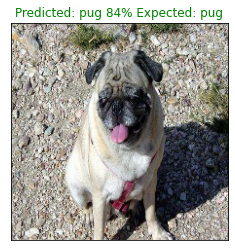

In [110]:
plot_pred(prediction_probabilities=predictions, labels=val_labels, images=val_images, n=53)

Make another function to view the model's top ten predictions

This function will:
* Take an input of prediction probabilities array, a ground truth array, and an integer
* Find the prediction using `get_pred_label()`
* Find the top 10:
  * Prediction probability indexes
  * Prediction probability values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green.

In [111]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """Plots the top 10 highest prediction confidences along with the truth label for sample n"""
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change the color of the true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

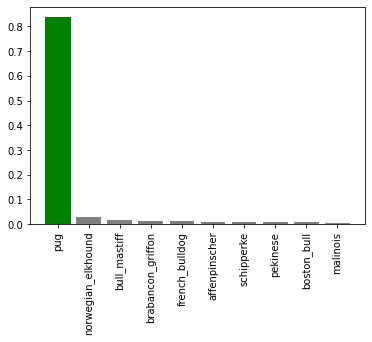

In [112]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=53)

Create subplots

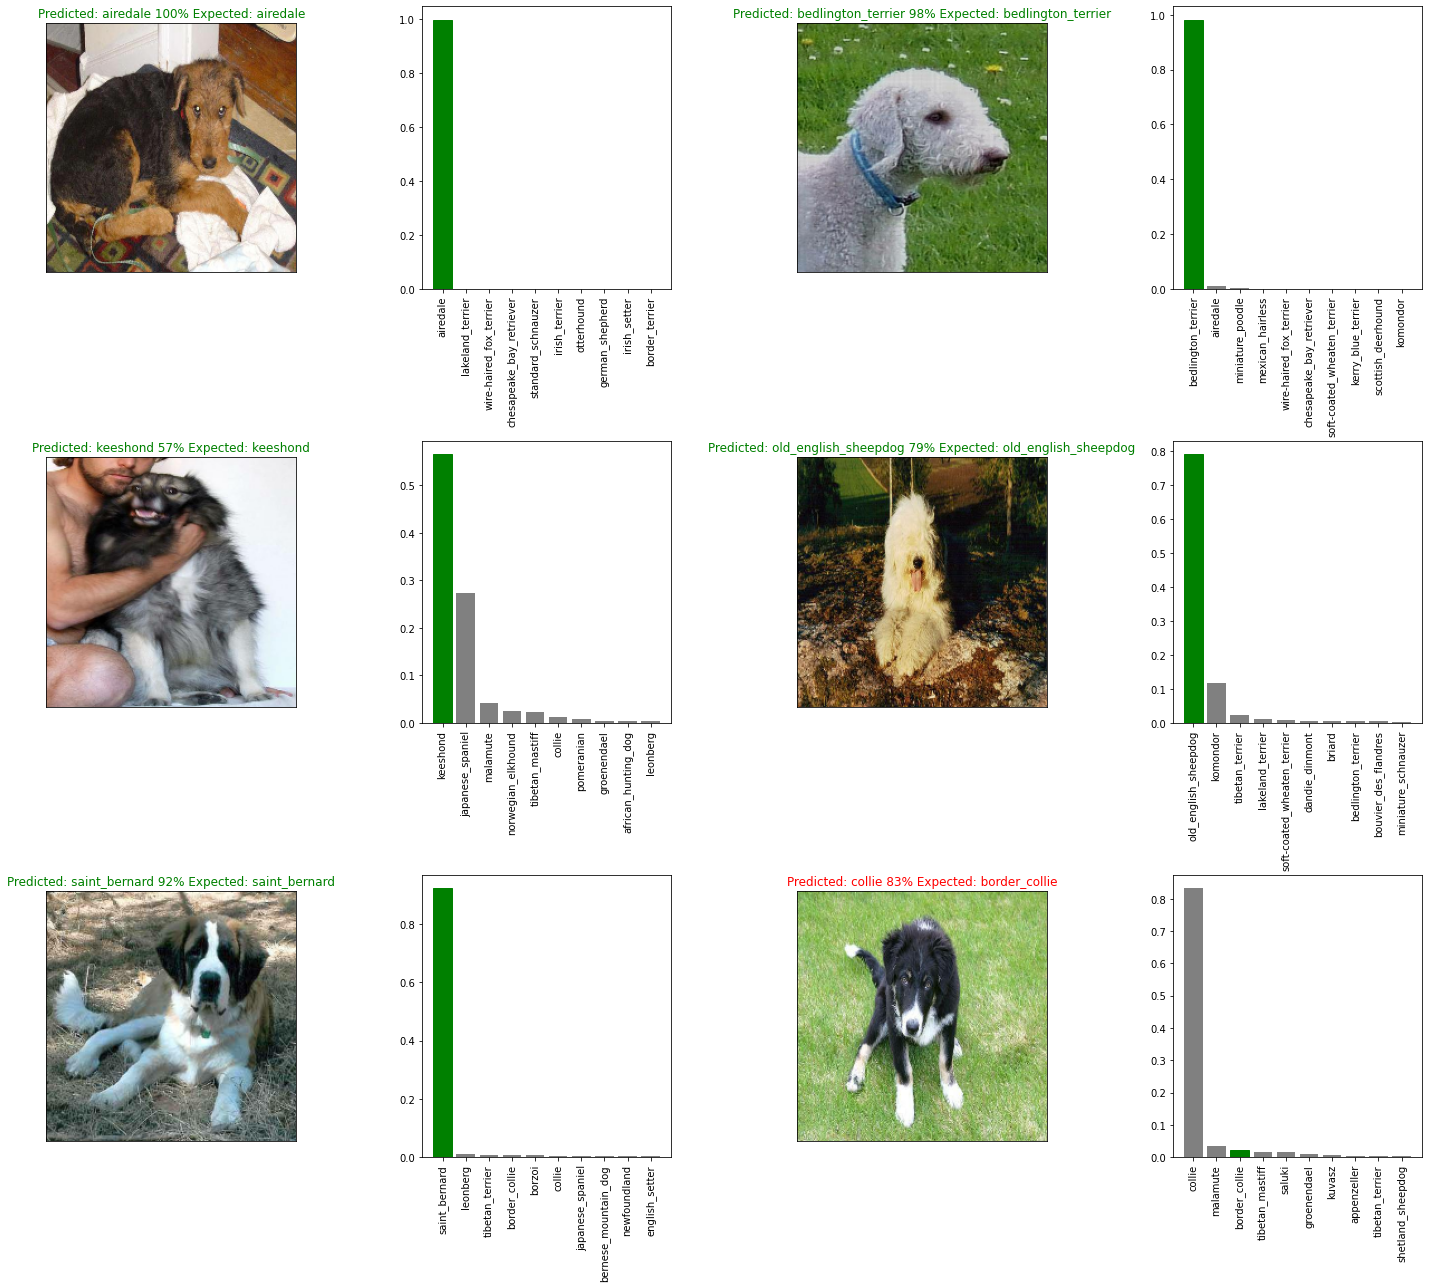

In [137]:
# Create a few predictions and their different values
i_multiplier = 4
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 6*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=0.4)
plt.show()

## Saving and loading a trained model

In [139]:
# Create a function to save a model
def save_model(model, suffix=None):
  """Saves a given model to the models directory and appends a suffix"""
  # Create a model directory pathname wth current time
  modeldir = os.path.join("drive/My Drive/Colab Notebooks/dog-breed-identification/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5"
  print(f"Saving model to: {model_path}")
  model.save(model_path)
  return model_path

In [144]:
# Create a function to load a trained model
def load_model(model_path):
  """Loads a saved model from a path"""
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer": hub.KerasLayer})
  return model

Make sure the functions work

In [142]:
# Save the model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/My Drive/Colab Notebooks/dog-breed-identification/models/20200730-18531596135222-1000-images-mobilenetv2-Adam.h5


'drive/My Drive/Colab Notebooks/dog-breed-identification/models/20200730-18531596135222-1000-images-mobilenetv2-Adam.h5'

In [145]:
# Laod a trained model
loaded_1000_image_model = load_model("drive/My Drive/Colab Notebooks/dog-breed-identification/models/20200730-18531596135222-1000-images-mobilenetv2-Adam.h5")

Loading saved model from: drive/My Drive/Colab Notebooks/dog-breed-identification/models/20200730-18531596135222-1000-images-mobilenetv2-Adam.h5


In [146]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 115ms/step - loss: 1.2144 - accuracy: 0.6850


[1.2143968343734741, 0.6850000023841858]

In [147]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 129ms/step - loss: 1.2144 - accuracy: 0.6850


[1.2143968343734741, 0.6850000023841858]

## Training a model on the full data

In [150]:
# Create a data batch with the full dataset
full_data = create_data_batches(x, y)

Creating training data batches...


In [151]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [152]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [153]:
# Create full modell callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data. Can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note**: The cell below will take about 30 minutes because all 10,000+ images have to be loaded to the GPU memory.

In [154]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 7692s 24s/step - loss: 1.3559 - accuracy: 0.6669
Epoch 2/100
320/320 [==============================] - 53s 166ms/step - loss: 0.4038 - accuracy: 0.8810
Epoch 3/100
320/320 [==============================] - 53s 165ms/step - loss: 0.2374 - accuracy: 0.9346
Epoch 4/100
320/320 [==============================] - 52s 163ms/step - loss: 0.1534 - accuracy: 0.9621
Epoch 5/100
320/320 [==============================] - 52s 161ms/step - loss: 0.1050 - accuracy: 0.9790
Epoch 6/100
320/320 [==============================] - 52s 163ms/step - loss: 0.0786 - accuracy: 0.9847
Epoch 7/100
320/320 [==============================] - 51s 160ms/step - loss: 0.0586 - accuracy: 0.9919
Epoch 8/100
320/320 [==============================] - 51s 159ms/step - loss: 0.0458 - accuracy: 0.9945
Epoch 9/100
320/320 [==============================] - 51s 160ms/step - loss: 0.0357 - accuracy: 0.9969
Epoch 10/100
320/320 [==============================] - 51s 159m

In [155]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/My Drive/Colab Notebooks/dog-breed-identification/models/20200730-22101596147017-full-image-set-mobilenetv2-Adam.h5


'drive/My Drive/Colab Notebooks/dog-breed-identification/models/20200730-22101596147017-full-image-set-mobilenetv2-Adam.h5'

In [156]:
loaded_full_model = load_model("drive/My Drive/Colab Notebooks/dog-breed-identification/models/20200730-22101596147017-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from: drive/My Drive/Colab Notebooks/dog-breed-identification/models/20200730-22101596147017-full-image-set-mobilenetv2-Adam.h5


## Making predictions on the test dataset

To make predictions on the test data, it has to be converted to data batches first.

`create_data_batches()` function that was created above can convert the data into test batches.

Steps to take before making predictions:
* Get the test image filenames
* Covert the filename into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True`
* Make predictions by passing the test batches to the `predict()` method on the model.

In [164]:
# Load the test image filename
test_path = "drive/My Drive/Colab Notebooks/dog-breed-identification/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Colab Notebooks/dog-breed-identification/test/f4b31ede23331910d4f15664be4db5d3.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/test/f53ae57b0cae92b14f87716a815d66e9.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/test/f50cf15ef4c06e63d9483b48d7bead6b.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/test/f5b7912d2f7ab4c4a237ca7008212e7c.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/test/f5a82b8243ff2845cc9bbe040e70dbf8.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/test/f6074efff140894b18a6b73e8a3886e7.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/test/f574f558d78db4e616e91f5dd5347409.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/test/f633268243572d8a8607d5959a0d3456.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/test/f5ae72b9aff8a7671358eb22a54229bc.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/test/f5cab113e1dab255ca2

In [165]:
len(test_filenames)

10357

In [166]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


**Note:** The `predict()` function will take a long time to run since there are 10,000+ images. This will take about an hour.


In [167]:
# Make predictions on the test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

  9/324 [..............................] - ETA: 2:01:54

KeyboardInterrupt: ignored

In [ ]:
np.savetxt("drive/My Drive/Colab Notebooks/dog-breed-identification/preds_array.csv", delimiter=",")

In [168]:
test_predictions = np.loadtxt("drive/My Drive/Colab Notebooks/dog-breed-identification/preds_array.csv", delimiter=",")

In [169]:
test_predictions[:10]

array([[1.61196489e-09, 3.44086413e-12, 2.32834394e-11, ...,
        1.06917716e-13, 1.58530451e-08, 1.52161670e-06],
       [3.17894322e-10, 3.20088262e-14, 1.85374840e-10, ...,
        7.00588814e-08, 1.88822238e-08, 2.56980937e-10],
       [4.27301083e-09, 1.84139528e-13, 1.11784948e-09, ...,
        2.71949238e-12, 2.23927123e-06, 7.41860809e-11],
       ...,
       [4.47232779e-10, 4.28004029e-07, 4.11986996e-08, ...,
        4.65437893e-07, 8.21722967e-10, 8.86002116e-09],
       [3.50528079e-11, 1.94377336e-03, 1.44941642e-10, ...,
        1.56135718e-06, 6.13228721e-08, 7.32120961e-12],
       [1.23221771e-08, 3.08354520e-09, 1.87174110e-10, ...,
        8.16165635e-10, 9.98905063e-01, 6.73740752e-09]])

## Preparing test dataset predictions for Kaggle

Steps to get the data in the desired form:
* Create a pandas DataFrame with an ID column and a column for each dog breed.
* Add data to the ID column by extracting the test image IDs from their filepaths.
* Export the DataFrame as a CSV.

In [171]:
# Create a pandas DataFrame
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df[:5]

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [172]:
test_filenames[:5]

['drive/My Drive/Colab Notebooks/dog-breed-identification/test/f4b31ede23331910d4f15664be4db5d3.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/test/f53ae57b0cae92b14f87716a815d66e9.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/test/f50cf15ef4c06e63d9483b48d7bead6b.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/test/f5b7912d2f7ab4c4a237ca7008212e7c.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-identification/test/f5a82b8243ff2845cc9bbe040e70dbf8.jpg']

In [176]:
# Append test image IDs to predictions dataframe
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]

In [178]:
preds_df["id"] = test_ids

In [179]:
preds_df.head()

id  ... yorkshire_terrier
0  f4b31ede23331910d4f15664be4db5d3  ...               NaN
1  f53ae57b0cae92b14f87716a815d66e9  ...               NaN
2  f50cf15ef4c06e63d9483b48d7bead6b  ...               NaN
3  f5b7912d2f7ab4c4a237ca7008212e7c  ...               NaN
4  f5a82b8243ff2845cc9bbe040e70dbf8  ...               NaN

[5 rows x 121 columns]

In [180]:
# Add the predictions probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  ... yorkshire_terrier
0  f4b31ede23331910d4f15664be4db5d3  ...       1.52162e-06
1  f53ae57b0cae92b14f87716a815d66e9  ...       2.56981e-10
2  f50cf15ef4c06e63d9483b48d7bead6b  ...       7.41861e-11
3  f5b7912d2f7ab4c4a237ca7008212e7c  ...       6.13453e-11
4  f5a82b8243ff2845cc9bbe040e70dbf8  ...       1.31887e-06

[5 rows x 121 columns]

In [182]:
preds_df.to_csv("drive/My Drive/Colab Notebooks/dog-breed-identification/full_model_predictions_mobilenetv2.csv", index=False)

## Making predictions on custom images

* Get the filepaths
* Turn the filepaths into batches using `create_data_batches(test_data=True)`
* Pass the custom image data batch to the model's `predict()`
* Convert the prediction output probabilities to prediction labels
* Compare the predicted labels to the custom images.

In [205]:
# Get custom paths
custom_path = "drive/My Drive/Colab Notebooks/dog-breed-identification/custom_dog_images/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [206]:
# Turn the custom images into data batches
custom_data = create_data_batches(custom_image_paths, test_data=True)

Creating test data batches...


In [207]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [208]:
custom_preds.shape

(9, 120)

In [209]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['japanese_spaniel',
 'irish_water_spaniel',
 'leonberg',
 'kelpie',
 'bluetick',
 'doberman',
 'entlebucher',
 'newfoundland',
 'gordon_setter']

In [210]:
# Get custom images (unbatchify() function won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

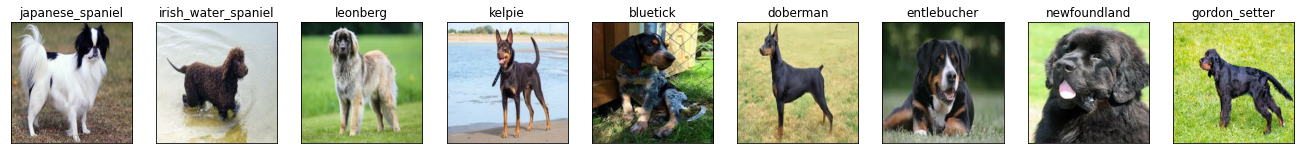

In [222]:
# Check custom image predictions
plt.figure(figsize=(23, 20))
for i, image in enumerate(custom_images):
  plt.subplot(1, 9, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)